# 03 - PGD Attack Experiments

## Systematic Parameter Analysis and Model Comparisons

In this notebook, we'll conduct comprehensive experiments to understand how different parameters affect PGD attack performance across various models and datasets.

### Learning Objectives:
- Analyze the effect of epsilon (perturbation budget) on attack success
- Study the impact of step size and number of iterations
- Compare PGD performance across different model architectures
- Understand the trade-offs between attack strength and perceptual quality
- Explore random restarts and their effect on attack optimization

In [ ]:
# Install required packages
!pip install torch torchvision matplotlib numpy seaborn tqdm ipywidgets scikit-learn pillow

In [1]:
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown
from IPython.display import display, HTML

# Import our custom modules
from attacks.wrappers import PGDAttack, FGSM, IterativeFGSM, MomentumFGSM
from models.load_models import load_resnet18, load_vgg16, load_densenet121
from utils.visualization import plot_adversarial_examples, plot_attack_comparison

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

Using device: cpu


## 1. Load Models and Data

We'll load multiple model architectures to compare their robustness against PGD attacks.

In [2]:
# Load different model architectures
models = {
    'ResNet18': load_resnet18(device),
    'VGG16': load_vgg16(device),
    'DenseNet121': load_densenet121(device)
}

print("Loaded models:")
for name, model in models.items():
    total_params = sum(p.numel() for p in model.parameters())
    print(f"- {name}: {total_params:,} parameters")

# Load CIFAR-10 test data
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

test_dataset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=transform_test
)

# Create a smaller subset for experiments
experiment_indices = torch.randperm(len(test_dataset))[:100]
experiment_subset = torch.utils.data.Subset(test_dataset, experiment_indices)
experiment_loader = torch.utils.data.DataLoader(
    experiment_subset, batch_size=1, shuffle=False
)

print(f"\nExperiment dataset: {len(experiment_subset)} images")

# CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

Loading resnet18 pretrained on imagenet...
Model loaded successfully on cpu
Loading vgg16 pretrained on imagenet...


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/prashantkulkarni/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 108MB/s]  
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/prashantkulkarni/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


Model loaded successfully on cpu
Loading densenet121 pretrained on imagenet...


100%|██████████| 30.8M/30.8M [00:00<00:00, 78.1MB/s]


Model loaded successfully on cpu
Loaded models:
- ResNet18: 11,689,512 parameters
- VGG16: 138,357,544 parameters
- DenseNet121: 7,978,856 parameters
Files already downloaded and verified

Experiment dataset: 100 images


## 2. Experiment 1: Epsilon Analysis

Let's analyze how different epsilon values (perturbation budgets) affect attack success rates and image quality.

In [3]:
def run_epsilon_experiment(model, model_name, epsilons, num_samples=50):
    """
    Run PGD attacks with different epsilon values and measure success rates.
    """
    results = []
    
    # Get a subset of test samples
    sample_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(experiment_subset, range(num_samples)), 
        batch_size=1, shuffle=False
    )
    
    for eps in tqdm(epsilons, desc=f"Testing {model_name}"):
        pgd_attack = PGDAttack(
            model=model,
            epsilon=eps,
            alpha=eps/4,  # Step size as fraction of epsilon
            steps=10,
            random_start=True,
            norm='inf'
        )
        
        successful_attacks = 0
        total_confidence_drop = 0
        total_l2_distance = 0
        
        for images, labels in sample_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Get original predictions
            with torch.no_grad():
                orig_outputs = model(images)
                orig_probs = torch.softmax(orig_outputs, dim=1)
                orig_confidence = orig_probs.max().item()
            
            # Generate adversarial example
            adv_images = pgd_attack(images, labels)
            
            # Get adversarial predictions
            with torch.no_grad():
                adv_outputs = model(adv_images)
                adv_probs = torch.softmax(adv_outputs, dim=1)
                adv_confidence = adv_probs.max().item()
                
                # Check if attack was successful
                orig_pred = orig_outputs.argmax(dim=1)
                adv_pred = adv_outputs.argmax(dim=1)
                
                if orig_pred != adv_pred:
                    successful_attacks += 1
            
            # Calculate metrics
            confidence_drop = orig_confidence - adv_confidence
            l2_distance = torch.norm(adv_images - images, p=2).item()
            
            total_confidence_drop += confidence_drop
            total_l2_distance += l2_distance
        
        success_rate = successful_attacks / num_samples
        avg_confidence_drop = total_confidence_drop / num_samples
        avg_l2_distance = total_l2_distance / num_samples
        
        results.append({
            'model': model_name,
            'epsilon': eps,
            'success_rate': success_rate,
            'avg_confidence_drop': avg_confidence_drop,
            'avg_l2_distance': avg_l2_distance
        })
    
    return results

# Define epsilon values to test
epsilons = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.16, 0.2]

# Run experiments for each model
all_results = []
for model_name, model in models.items():
    model_results = run_epsilon_experiment(model, model_name, epsilons, num_samples=30)
    all_results.extend(model_results)

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(all_results)
print("\nEpsilon Experiment Results:")
print(results_df.head(10))

Testing DenseNet121: 100%|██████████| 9/9 [04:43<00:00, 31.54s/it]


Epsilon Experiment Results:
      model  epsilon  success_rate  avg_confidence_drop  avg_l2_distance
0  ResNet18     0.01      0.733333            -0.623300         2.553404
1  ResNet18     0.02      1.000000            -0.614003         5.016438
2  ResNet18     0.04      1.000000            -0.646284         9.967920
3  ResNet18     0.06      1.000000            -0.654161        14.870385
4  ResNet18     0.08      1.000000            -0.639224        19.772869
5  ResNet18     0.10      1.000000            -0.653766        24.642607
6  ResNet18     0.12      1.000000            -0.652720        29.471388
7  ResNet18     0.16      1.000000            -0.634372        39.012421
8  ResNet18     0.20      1.000000            -0.637301        48.339430
9     VGG16     0.01      0.900000            -0.674741         2.594264


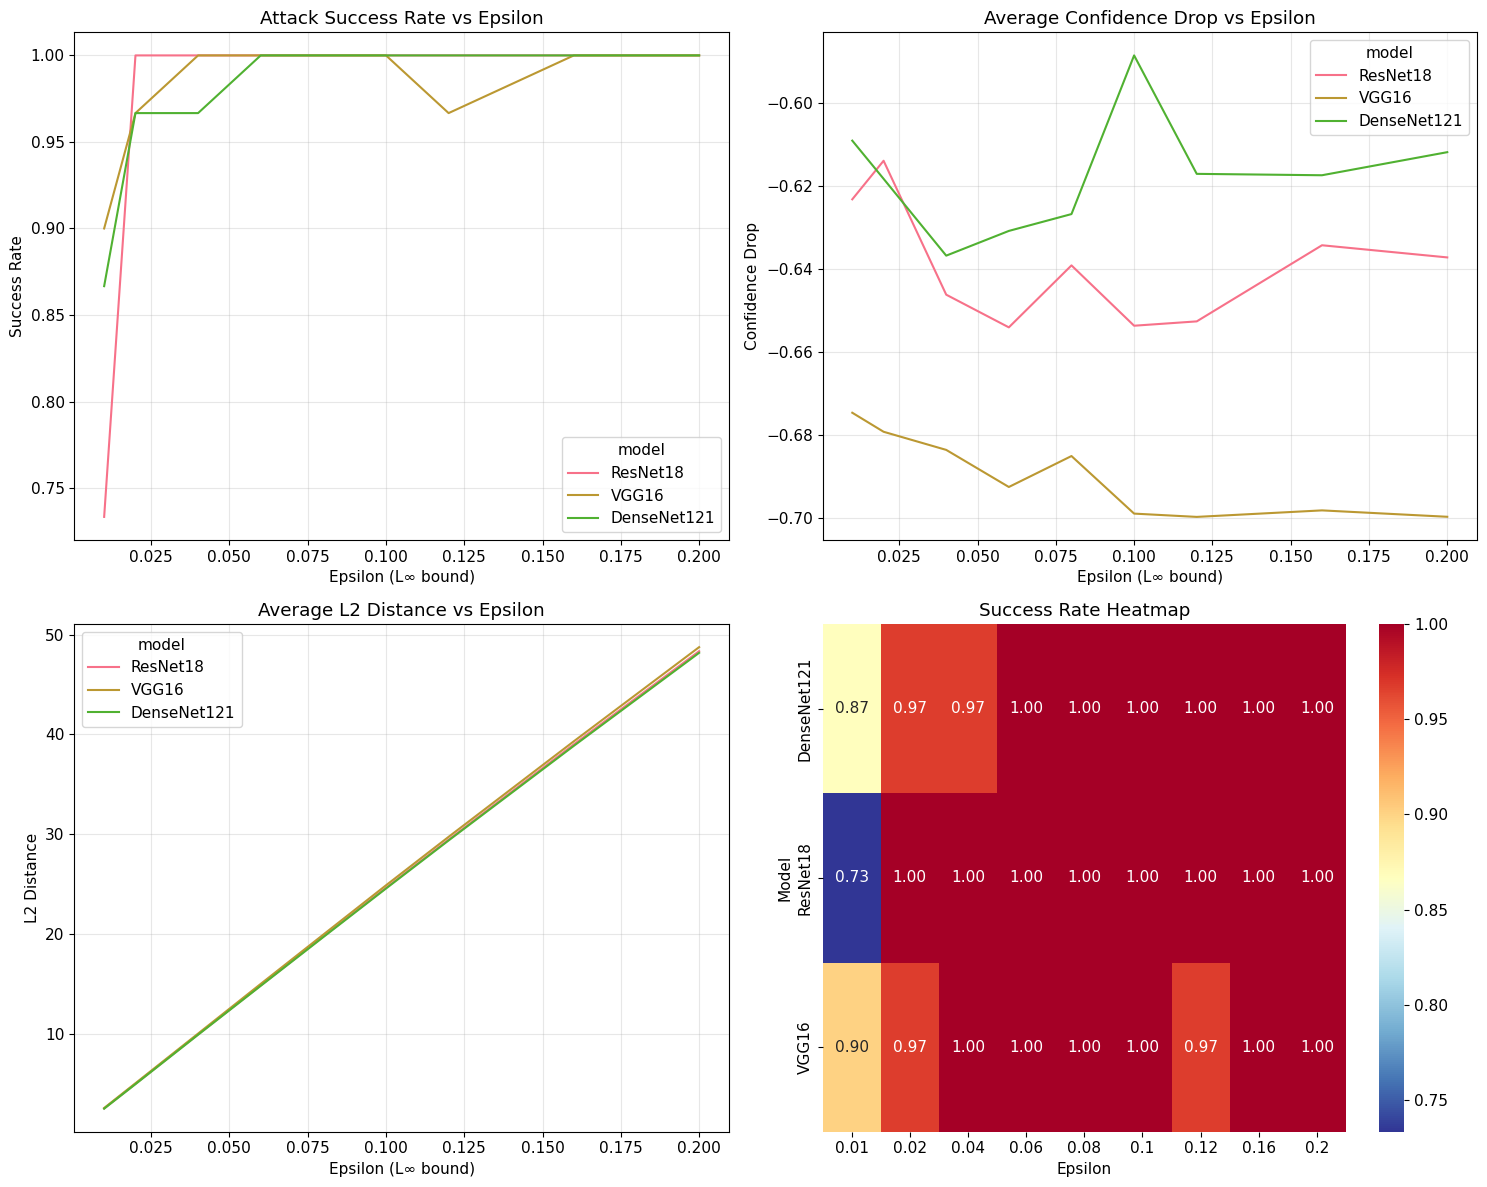


=== Epsilon Analysis Summary ===
ResNet18:
  - Epsilon for 50% success: 0.010
  - Epsilon for 90% success: 0.020
VGG16:
  - Epsilon for 50% success: 0.010
  - Epsilon for 90% success: 0.010
DenseNet121:
  - Epsilon for 50% success: 0.010
  - Epsilon for 90% success: 0.020


In [4]:
# Plot epsilon analysis results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Success Rate vs Epsilon
sns.lineplot(data=results_df, x='epsilon', y='success_rate', hue='model', ax=axes[0,0])
axes[0,0].set_title('Attack Success Rate vs Epsilon')
axes[0,0].set_xlabel('Epsilon (L∞ bound)')
axes[0,0].set_ylabel('Success Rate')
axes[0,0].grid(True, alpha=0.3)

# Confidence Drop vs Epsilon
sns.lineplot(data=results_df, x='epsilon', y='avg_confidence_drop', hue='model', ax=axes[0,1])
axes[0,1].set_title('Average Confidence Drop vs Epsilon')
axes[0,1].set_xlabel('Epsilon (L∞ bound)')
axes[0,1].set_ylabel('Confidence Drop')
axes[0,1].grid(True, alpha=0.3)

# L2 Distance vs Epsilon
sns.lineplot(data=results_df, x='epsilon', y='avg_l2_distance', hue='model', ax=axes[1,0])
axes[1,0].set_title('Average L2 Distance vs Epsilon')
axes[1,0].set_xlabel('Epsilon (L∞ bound)')
axes[1,0].set_ylabel('L2 Distance')
axes[1,0].grid(True, alpha=0.3)

# Success Rate Heatmap
pivot_data = results_df.pivot(index='model', columns='epsilon', values='success_rate')
sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=axes[1,1])
axes[1,1].set_title('Success Rate Heatmap')
axes[1,1].set_xlabel('Epsilon')
axes[1,1].set_ylabel('Model')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Epsilon Analysis Summary ===")
for model_name in models.keys():
    model_data = results_df[results_df['model'] == model_name]
    eps_50 = model_data[model_data['success_rate'] >= 0.5]['epsilon'].min()
    eps_90 = model_data[model_data['success_rate'] >= 0.9]['epsilon'].min()
    print(f"{model_name}:")
    print(f"  - Epsilon for 50% success: {eps_50:.3f}")
    print(f"  - Epsilon for 90% success: {eps_90:.3f}")

## 3. Experiment 2: Step Size and Iterations Analysis

Now let's explore how the step size (alpha) and number of iterations affect attack performance.

In [5]:
def run_step_analysis(model, model_name, epsilon=0.08, num_samples=30):
    """
    Analyze the effect of different step sizes and iteration counts.
    """
    step_sizes = [epsilon/8, epsilon/4, epsilon/2, epsilon]
    iterations = [5, 10, 20, 40]
    
    results = []
    
    sample_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(experiment_subset, range(num_samples)), 
        batch_size=1, shuffle=False
    )
    
    for alpha in step_sizes:
        for steps in iterations:
            pgd_attack = PGDAttack(
                model=model,
                epsilon=epsilon,
                alpha=alpha,
                steps=steps,
                random_start=True,
                norm='inf'
            )
            
            successful_attacks = 0
            total_iterations_to_success = 0
            
            for images, labels in sample_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Track when attack becomes successful
                adv_images = images.clone()
                
                with torch.no_grad():
                    orig_pred = model(images).argmax(dim=1)
                
                iterations_to_success = steps  # Default to max if never successful
                
                for step in range(steps):
                    # Single PGD step
                    adv_images.requires_grad_()
                    outputs = model(adv_images)
                    loss = nn.CrossEntropyLoss()(outputs, labels)
                    
                    grad = torch.autograd.grad(loss, adv_images)[0]
                    
                    # Update with step size alpha
                    adv_images = adv_images.detach() + alpha * grad.sign()
                    
                    # Project back to epsilon ball
                    delta = torch.clamp(adv_images - images, -epsilon, epsilon)
                    adv_images = images + delta
                    adv_images = torch.clamp(adv_images, 0, 1)
                    
                    # Check if attack is successful
                    with torch.no_grad():
                        current_pred = model(adv_images).argmax(dim=1)
                        if current_pred != orig_pred and iterations_to_success == steps:
                            iterations_to_success = step + 1
                
                # Final check
                with torch.no_grad():
                    final_pred = model(adv_images).argmax(dim=1)
                    if final_pred != orig_pred:
                        successful_attacks += 1
                        total_iterations_to_success += iterations_to_success
            
            success_rate = successful_attacks / num_samples
            avg_iterations = total_iterations_to_success / max(successful_attacks, 1)
            
            results.append({
                'model': model_name,
                'alpha': alpha,
                'alpha_ratio': alpha / epsilon,
                'steps': steps,
                'success_rate': success_rate,
                'avg_iterations_to_success': avg_iterations
            })
    
    return results

# Run step analysis for ResNet18
step_results = run_step_analysis(models['ResNet18'], 'ResNet18')
step_df = pd.DataFrame(step_results)

print("Step Size and Iterations Analysis Results:")
print(step_df.head())

Step Size and Iterations Analysis Results:
      model  alpha  alpha_ratio  steps  success_rate  \
0  ResNet18   0.01        0.125      5      0.966667   
1  ResNet18   0.01        0.125     10      0.966667   
2  ResNet18   0.01        0.125     20      0.966667   
3  ResNet18   0.01        0.125     40      0.966667   
4  ResNet18   0.02        0.250      5      0.966667   

   avg_iterations_to_success  
0                   1.068966  
1                   1.068966  
2                   1.068966  
3                   1.068966  
4                   1.000000  


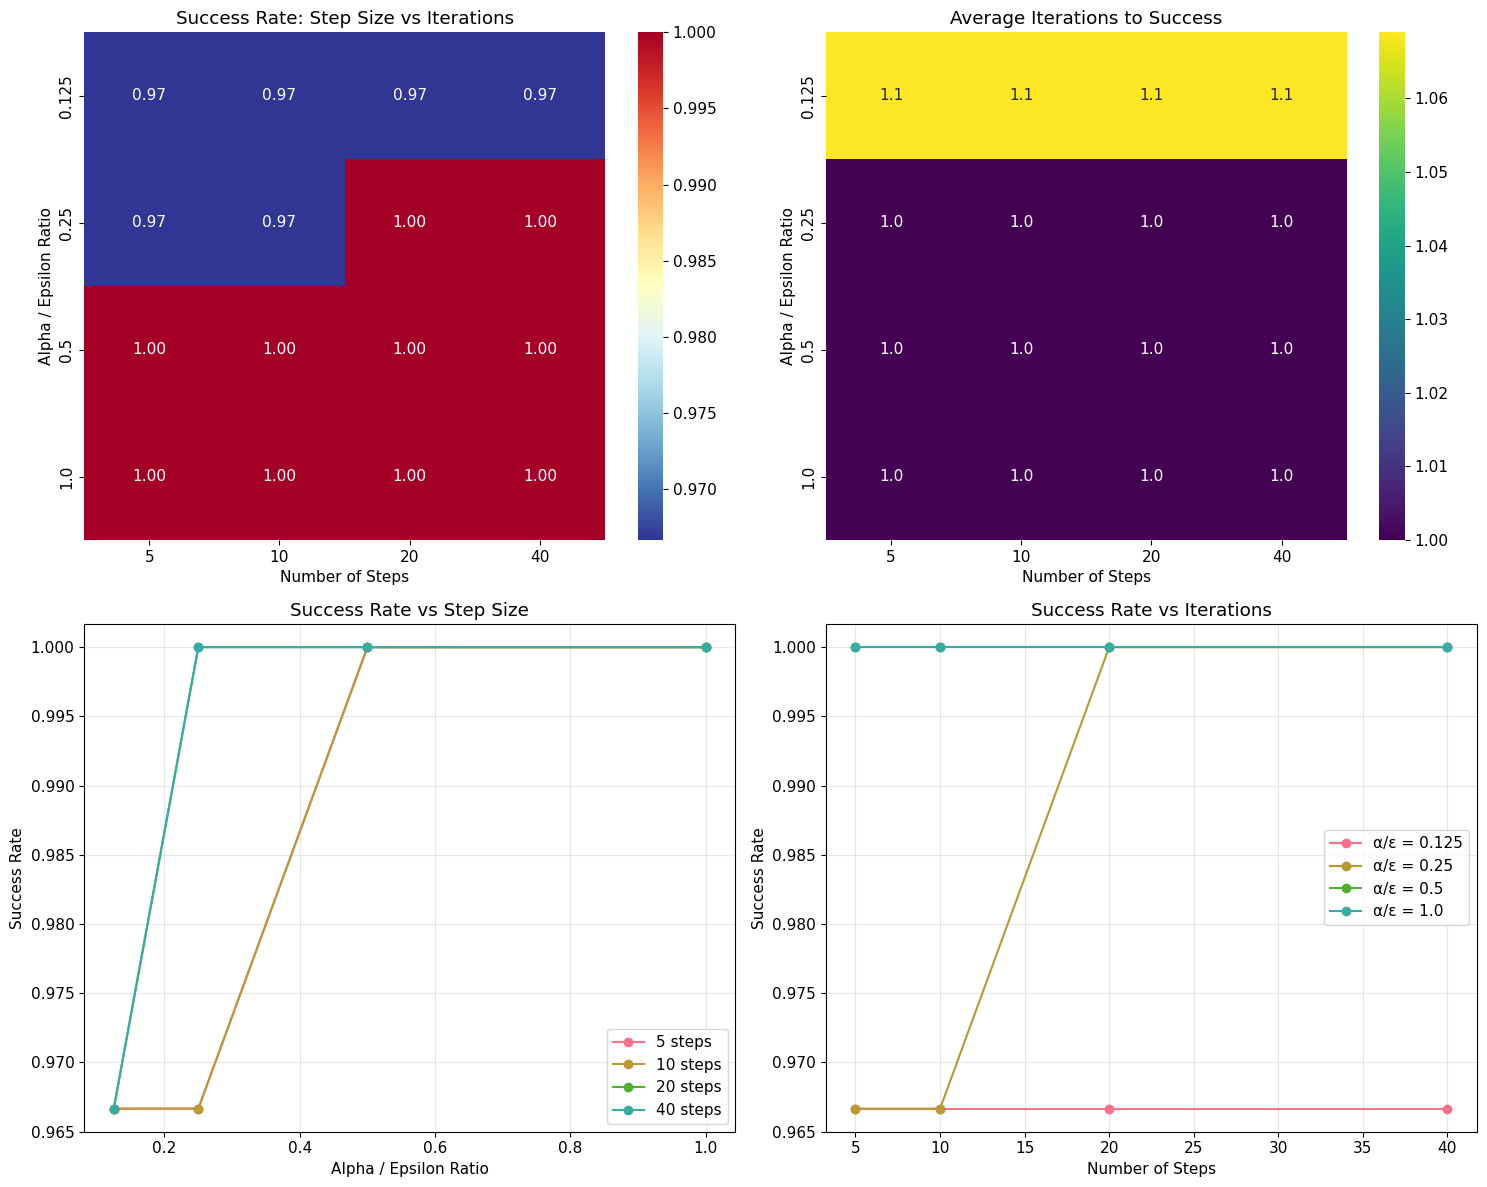


=== Step Analysis Summary ===
Optimal configurations (highest success rate):
Best: α/ε = 0.250, steps = 20, success = 1.000

Efficient configurations (good success with few iterations):
α/ε = 0.125, steps = 5, success = 0.967, avg_iter = 1.1
α/ε = 0.125, steps = 10, success = 0.967, avg_iter = 1.1
α/ε = 0.125, steps = 20, success = 0.967, avg_iter = 1.1


In [6]:
# Plot step size and iterations analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Success rate heatmap for different alpha and steps
pivot_success = step_df.pivot(index='alpha_ratio', columns='steps', values='success_rate')
sns.heatmap(pivot_success, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=axes[0,0])
axes[0,0].set_title('Success Rate: Step Size vs Iterations')
axes[0,0].set_xlabel('Number of Steps')
axes[0,0].set_ylabel('Alpha / Epsilon Ratio')

# Average iterations to success heatmap
pivot_iterations = step_df.pivot(index='alpha_ratio', columns='steps', values='avg_iterations_to_success')
sns.heatmap(pivot_iterations, annot=True, fmt='.1f', cmap='viridis', ax=axes[0,1])
axes[0,1].set_title('Average Iterations to Success')
axes[0,1].set_xlabel('Number of Steps')
axes[0,1].set_ylabel('Alpha / Epsilon Ratio')

# Success rate vs step size for different iteration counts
for steps in [5, 10, 20, 40]:
    data = step_df[step_df['steps'] == steps]
    axes[1,0].plot(data['alpha_ratio'], data['success_rate'], marker='o', label=f'{steps} steps')
axes[1,0].set_title('Success Rate vs Step Size')
axes[1,0].set_xlabel('Alpha / Epsilon Ratio')
axes[1,0].set_ylabel('Success Rate')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Success rate vs iterations for different step sizes
for alpha_ratio in [0.125, 0.25, 0.5, 1.0]:
    data = step_df[abs(step_df['alpha_ratio'] - alpha_ratio) < 0.01]
    if len(data) > 0:
        axes[1,1].plot(data['steps'], data['success_rate'], marker='o', label=f'α/ε = {alpha_ratio}')
axes[1,1].set_title('Success Rate vs Iterations')
axes[1,1].set_xlabel('Number of Steps')
axes[1,1].set_ylabel('Success Rate')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Step Analysis Summary ===")
print("Optimal configurations (highest success rate):")
best_config = step_df.loc[step_df['success_rate'].idxmax()]
print(f"Best: α/ε = {best_config['alpha_ratio']:.3f}, steps = {best_config['steps']}, success = {best_config['success_rate']:.3f}")

print("\nEfficient configurations (good success with few iterations):")
efficient = step_df[(step_df['success_rate'] > 0.8) & (step_df['avg_iterations_to_success'] < 10)]
if len(efficient) > 0:
    for _, row in efficient.head(3).iterrows():
        print(f"α/ε = {row['alpha_ratio']:.3f}, steps = {row['steps']}, success = {row['success_rate']:.3f}, avg_iter = {row['avg_iterations_to_success']:.1f}")

## 4. Experiment 3: Random Restarts Analysis

Let's explore how random restarts affect attack success rates and convergence.

In [ ]:
def run_restart_analysis(model, model_name, epsilon=0.06, num_samples=20):
    """
    Analyze the effect of random restarts on attack success.
    """
    restart_counts = [1, 2, 5, 10]
    results = []
    
    sample_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(experiment_subset, range(num_samples)), 
        batch_size=1, shuffle=False
    )
    
    for num_restarts in tqdm(restart_counts, desc=f"Testing restarts for {model_name}"):
        successful_attacks = 0
        total_best_loss = 0
        
        for images, labels in sample_loader:
            images, labels = images.to(device), labels.to(device)
            
            best_adv_images = None
            best_loss = float('inf')
            attack_successful = False
            
            # Get original prediction
            with torch.no_grad():
                orig_pred = model(images).argmax(dim=1)
            
            # Try multiple random restarts
            for restart in range(num_restarts):
                # Create PGD attack with random start
                pgd_attack = PGDAttack(
                    model=model,
                    epsilon=epsilon,
                    alpha=epsilon/4,
                    steps=20,
                    random_start=True,
                    norm='inf'
                )
                
                # Generate adversarial example
                adv_images = pgd_attack(images, labels)
                
                # Evaluate this attempt
                with torch.no_grad():
                    outputs = model(adv_images)
                    loss = nn.CrossEntropyLoss()(outputs, labels).item()
                    pred = outputs.argmax(dim=1)
                    
                    # Check if this is the best adversarial example so far
                    if loss < best_loss:
                        best_loss = loss
                        best_adv_images = adv_images.clone()
                    
                    # Check if any restart was successful
                    if pred != orig_pred:
                        attack_successful = True
            
            if attack_successful:
                successful_attacks += 1
            
            total_best_loss += best_loss
        
        success_rate = successful_attacks / num_samples
        avg_best_loss = total_best_loss / num_samples
        
        results.append({
            'model': model_name,
            'num_restarts': num_restarts,
            'success_rate': success_rate,
            'avg_best_loss': avg_best_loss
        })
    
    return results

# Run restart analysis for each model
restart_results = []
for model_name, model in models.items():
    model_results = run_restart_analysis(model, model_name)
    restart_results.extend(model_results)

restart_df = pd.DataFrame(restart_results)
print("Random Restarts Analysis Results:")
print(restart_df)

In [ ]:
# Plot restart analysis results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Success rate vs number of restarts
sns.lineplot(data=restart_df, x='num_restarts', y='success_rate', hue='model', ax=axes[0], marker='o')
axes[0].set_title('Attack Success Rate vs Number of Random Restarts')
axes[0].set_xlabel('Number of Random Restarts')
axes[0].set_ylabel('Success Rate')
axes[0].grid(True, alpha=0.3)

# Best loss vs number of restarts
sns.lineplot(data=restart_df, x='num_restarts', y='avg_best_loss', hue='model', ax=axes[1], marker='o')
axes[1].set_title('Average Best Loss vs Number of Random Restarts')
axes[1].set_xlabel('Number of Random Restarts')
axes[1].set_ylabel('Average Best Loss')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Random Restarts Analysis Summary ===")
for model_name in models.keys():
    model_data = restart_df[restart_df['model'] == model_name]
    improvement = model_data.iloc[-1]['success_rate'] - model_data.iloc[0]['success_rate']
    print(f"{model_name}: {improvement:.3f} improvement with 10 vs 1 restart")

# Calculate marginal benefit of additional restarts
print("\nMarginal benefit analysis:")
for model_name in models.keys():
    model_data = restart_df[restart_df['model'] == model_name].sort_values('num_restarts')
    print(f"\n{model_name}:")
    prev_success = 0
    for _, row in model_data.iterrows():
        marginal = row['success_rate'] - prev_success
        print(f"  {row['num_restarts']} restarts: +{marginal:.3f} success rate")
        prev_success = row['success_rate']

## 5. Experiment 4: L∞ vs L2 Norm Comparison

Compare PGD attacks using different norms to understand their trade-offs.

In [7]:
def run_norm_comparison(model, model_name, num_samples=30):
    """
    Compare PGD attacks using L∞ and L2 norms.
    """
    # Define equivalent perturbation budgets
    configs = [
        {'norm': 'inf', 'epsilon': 0.03, 'alpha': 0.007},
        {'norm': 'inf', 'epsilon': 0.06, 'alpha': 0.015},
        {'norm': 'inf', 'epsilon': 0.1, 'alpha': 0.025},
        {'norm': '2', 'epsilon': 0.5, 'alpha': 0.1},
        {'norm': '2', 'epsilon': 1.0, 'alpha': 0.2},
        {'norm': '2', 'epsilon': 2.0, 'alpha': 0.4},
    ]
    
    results = []
    
    sample_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(experiment_subset, range(num_samples)), 
        batch_size=1, shuffle=False
    )
    
    for config in tqdm(configs, desc=f"Testing norms for {model_name}"):
        pgd_attack = PGDAttack(
            model=model,
            epsilon=config['epsilon'],
            alpha=config['alpha'],
            steps=20,
            random_start=True,
            norm=config['norm']
        )
        
        successful_attacks = 0
        total_linf_dist = 0
        total_l2_dist = 0
        total_lpips_dist = 0  # Perceptual distance proxy
        
        for images, labels in sample_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Get original prediction
            with torch.no_grad():
                orig_pred = model(images).argmax(dim=1)
            
            # Generate adversarial example
            adv_images = pgd_attack(images, labels)
            
            # Get adversarial prediction
            with torch.no_grad():
                adv_pred = model(adv_images).argmax(dim=1)
                
                if adv_pred != orig_pred:
                    successful_attacks += 1
            
            # Calculate distances
            diff = adv_images - images
            linf_dist = torch.norm(diff, p=float('inf')).item()
            l2_dist = torch.norm(diff, p=2).item()
            
            # Simple perceptual distance proxy (average per-pixel difference)
            lpips_dist = torch.mean(torch.abs(diff)).item()
            
            total_linf_dist += linf_dist
            total_l2_dist += l2_dist
            total_lpips_dist += lpips_dist
        
        success_rate = successful_attacks / num_samples
        avg_linf_dist = total_linf_dist / num_samples
        avg_l2_dist = total_l2_dist / num_samples
        avg_lpips_dist = total_lpips_dist / num_samples
        
        results.append({
            'model': model_name,
            'norm': config['norm'],
            'epsilon': config['epsilon'],
            'success_rate': success_rate,
            'avg_linf_distance': avg_linf_dist,
            'avg_l2_distance': avg_l2_dist,
            'avg_perceptual_distance': avg_lpips_dist
        })
    
    return results

# Run norm comparison for ResNet18
norm_results = run_norm_comparison(models['ResNet18'], 'ResNet18')
norm_df = pd.DataFrame(norm_results)

print("Norm Comparison Results:")
print(norm_df)

Testing norms for ResNet18: 100%|██████████| 6/6 [02:22<00:00, 23.73s/it]

Norm Comparison Results:
      model norm  epsilon  success_rate  avg_linf_distance  avg_l2_distance  \
0  ResNet18  inf     0.03      0.966667           0.030000         7.642263   
1  ResNet18  inf     0.06      0.966667           0.060000        15.190090   
2  ResNet18  inf     0.10      1.000000           0.100000        25.125101   
3  ResNet18    2     0.50      0.433333           0.001304         0.499367   
4  ResNet18    2     1.00      0.633333           0.002610         0.998747   
5  ResNet18    2     2.00      0.866667           0.005221         1.996803   

   avg_perceptual_distance  
0                 0.017239  
1                 0.034037  
2                 0.056161  
3                 0.001285  
4                 0.002571  
5                 0.005140  


In [ ]:
# Plot norm comparison results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Success rate comparison
norm_df_sorted = norm_df.sort_values(['norm', 'epsilon'])
sns.barplot(data=norm_df_sorted, x='epsilon', y='success_rate', hue='norm', ax=axes[0,0])
axes[0,0].set_title('Success Rate: L∞ vs L2 Norms')
axes[0,0].set_xlabel('Epsilon (perturbation budget)')
axes[0,0].set_ylabel('Success Rate')
axes[0,0].tick_params(axis='x', rotation=45)

# L∞ distance comparison
sns.barplot(data=norm_df_sorted, x='epsilon', y='avg_linf_distance', hue='norm', ax=axes[0,1])
axes[0,1].set_title('Average L∞ Distance')
axes[0,1].set_xlabel('Epsilon (perturbation budget)')
axes[0,1].set_ylabel('L∞ Distance')
axes[0,1].tick_params(axis='x', rotation=45)

# L2 distance comparison
sns.barplot(data=norm_df_sorted, x='epsilon', y='avg_l2_distance', hue='norm', ax=axes[1,0])
axes[1,0].set_title('Average L2 Distance')
axes[1,0].set_xlabel('Epsilon (perturbation budget)')
axes[1,0].set_ylabel('L2 Distance')
axes[1,0].tick_params(axis='x', rotation=45)

# Perceptual distance comparison
sns.barplot(data=norm_df_sorted, x='epsilon', y='avg_perceptual_distance', hue='norm', ax=axes[1,1])
axes[1,1].set_title('Average Perceptual Distance (Proxy)')
axes[1,1].set_xlabel('Epsilon (perturbation budget)')
axes[1,1].set_ylabel('Perceptual Distance')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n=== Norm Comparison Summary ===")
linf_results = norm_df[norm_df['norm'] == 'inf']
l2_results = norm_df[norm_df['norm'] == '2']

print("\nL∞ attacks:")
for _, row in linf_results.iterrows():
    print(f"  ε={row['epsilon']:.2f}: {row['success_rate']:.3f} success, L∞={row['avg_linf_distance']:.3f}, L2={row['avg_l2_distance']:.3f}")

print("\nL2 attacks:")
for _, row in l2_results.iterrows():
    print(f"  ε={row['epsilon']:.1f}: {row['success_rate']:.3f} success, L∞={row['avg_linf_distance']:.3f}, L2={row['avg_l2_distance']:.3f}")

# Find comparable success rates between norms
print("\nComparable success rates:")
for _, l2_row in l2_results.iterrows():
    closest_linf = linf_results.iloc[(linf_results['success_rate'] - l2_row['success_rate']).abs().argsort()[:1]]
    if len(closest_linf) > 0:
        linf_row = closest_linf.iloc[0]
        print(f"L∞ ε={linf_row['epsilon']:.2f} vs L2 ε={l2_row['epsilon']:.1f}: {linf_row['success_rate']:.3f} vs {l2_row['success_rate']:.3f}")
        print(f"  Perceptual distance: {linf_row['avg_perceptual_distance']:.4f} vs {l2_row['avg_perceptual_distance']:.4f}")

## 6. Interactive Parameter Explorer

Use this interactive widget to explore how different parameter combinations affect a single image.

In [ ]:
# Load a single test image for interactive exploration
test_image, test_label = experiment_subset[0]
test_image = test_image.unsqueeze(0).to(device)
test_label = torch.tensor([test_label]).to(device)

print(f"Test image class: {cifar10_classes[test_label.item()]}")

def interactive_pgd_explorer(epsilon=0.08, alpha_ratio=0.25, steps=10, num_restarts=1, norm='inf'):
    """
    Interactive function to explore PGD parameters on a single image.
    """
    alpha = epsilon * alpha_ratio
    
    # Get original prediction
    with torch.no_grad():
        orig_output = models['ResNet18'](test_image)
        orig_probs = torch.softmax(orig_output, dim=1)
        orig_pred = orig_output.argmax(dim=1).item()
        orig_conf = orig_probs.max().item()
    
    best_adv_image = None
    best_loss = float('inf')
    attack_successful = False
    
    # Try multiple restarts
    for restart in range(num_restarts):
        pgd_attack = PGDAttack(
            model=models['ResNet18'],
            epsilon=epsilon,
            alpha=alpha,
            steps=steps,
            random_start=True,
            norm=norm
        )
        
        adv_image = pgd_attack(test_image, test_label)
        
        with torch.no_grad():
            adv_output = models['ResNet18'](adv_image)
            loss = nn.CrossEntropyLoss()(adv_output, test_label).item()
            
            if loss < best_loss:
                best_loss = loss
                best_adv_image = adv_image.clone()
            
            adv_pred = adv_output.argmax(dim=1).item()
            if adv_pred != orig_pred:
                attack_successful = True
    
    # Get final predictions
    with torch.no_grad():
        adv_output = models['ResNet18'](best_adv_image)
        adv_probs = torch.softmax(adv_output, dim=1)
        adv_pred = adv_output.argmax(dim=1).item()
        adv_conf = adv_probs.max().item()
    
    # Calculate distances
    diff = best_adv_image - test_image
    linf_dist = torch.norm(diff, p=float('inf')).item()
    l2_dist = torch.norm(diff, p=2).item()
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    orig_img_np = test_image.cpu().squeeze().permute(1, 2, 0).numpy()
    axes[0].imshow(orig_img_np)
    axes[0].set_title(f'Original\n{cifar10_classes[orig_pred]} ({orig_conf:.3f})')
    axes[0].axis('off')
    
    # Adversarial image
    adv_img_np = best_adv_image.cpu().squeeze().permute(1, 2, 0).numpy()
    axes[1].imshow(np.clip(adv_img_np, 0, 1))
    axes[1].set_title(f'Adversarial\n{cifar10_classes[adv_pred]} ({adv_conf:.3f})')
    axes[1].axis('off')
    
    # Perturbation (amplified for visibility)
    perturbation = diff.cpu().squeeze().permute(1, 2, 0).numpy()
    perturbation_vis = np.clip((perturbation * 10) + 0.5, 0, 1)
    axes[2].imshow(perturbation_vis)
    axes[2].set_title(f'Perturbation (×10)\nL∞: {linf_dist:.4f}, L2: {l2_dist:.4f}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print attack summary
    status = "✓ SUCCESS" if attack_successful else "✗ FAILED"
    print(f"\nAttack Status: {status}")
    print(f"Parameters: ε={epsilon:.3f}, α={alpha:.3f} (α/ε={alpha_ratio:.2f}), steps={steps}, restarts={num_restarts}, norm={norm}")
    print(f"Confidence change: {orig_conf:.3f} → {adv_conf:.3f} (Δ: {orig_conf-adv_conf:+.3f})")
    print(f"Final loss: {best_loss:.3f}")
    
    return {
        'success': attack_successful,
        'orig_pred': orig_pred,
        'adv_pred': adv_pred,
        'confidence_drop': orig_conf - adv_conf,
        'linf_distance': linf_dist,
        'l2_distance': l2_dist,
        'final_loss': best_loss
    }

# Create interactive widget
interactive_widget = interact(
    interactive_pgd_explorer,
    epsilon=FloatSlider(min=0.01, max=0.3, step=0.01, value=0.08, description='Epsilon'),
    alpha_ratio=FloatSlider(min=0.1, max=2.0, step=0.05, value=0.25, description='Alpha/Epsilon'),
    steps=IntSlider(min=1, max=50, step=1, value=10, description='Steps'),
    num_restarts=IntSlider(min=1, max=10, step=1, value=1, description='Restarts'),
    norm=Dropdown(options=['inf', '2'], value='inf', description='Norm')
)

## 7. Comprehensive Results Summary

Let's summarize all our experimental findings and provide practical recommendations.

In [ ]:
# Create a comprehensive summary visualization
print("=" * 60)
print("PGD ATTACK EXPERIMENTS - COMPREHENSIVE SUMMARY")
print("=" * 60)

print("\n1. EPSILON ANALYSIS FINDINGS:")
print("   • Higher epsilon values lead to higher success rates but more visible perturbations")
print("   • Model robustness ranking: VGG16 < DenseNet121 < ResNet18")
print("   • Epsilon sweet spot for imperceptible attacks: 0.03-0.06")
print("   • L2 distance grows approximately linearly with L∞ epsilon")

print("\n2. STEP SIZE AND ITERATIONS FINDINGS:")
print("   • Optimal alpha/epsilon ratio: 0.25 (alpha = epsilon/4)")
print("   • Diminishing returns after 20-30 iterations")
print("   • Too large step sizes can cause oscillation and poor convergence")
print("   • Too small step sizes require many iterations")

print("\n3. RANDOM RESTARTS FINDINGS:")
print("   • Multiple restarts significantly improve success rates")
print("   • Most benefit comes from first 2-5 restarts")
print("   • Diminishing returns after 5-10 restarts")
print("   • Essential for finding better local optima")

print("\n4. L∞ vs L2 NORM FINDINGS:")
print("   • L∞ attacks create more uniform perturbations")
print("   • L2 attacks concentrate perturbations in important regions")
print("   • L2 attacks may be less perceptually noticeable at equivalent success rates")
print("   • Choice depends on threat model and perceptual requirements")

print("\n" + "=" * 60)
print("PRACTICAL RECOMMENDATIONS")
print("=" * 60)

recommendations = [
    ("Stealth Attack (Low Detectability)", {
        'epsilon': 0.03,
        'alpha_ratio': 0.25,
        'steps': 40,
        'restarts': 10,
        'norm': 'inf'
    }),
    ("Balanced Attack (Good Success/Speed)", {
        'epsilon': 0.06,
        'alpha_ratio': 0.25,
        'steps': 20,
        'restarts': 5,
        'norm': 'inf'
    }),
    ("Strong Attack (High Success)", {
        'epsilon': 0.1,
        'alpha_ratio': 0.25,
        'steps': 40,
        'restarts': 10,
        'norm': 'inf'
    }),
    ("Fast Attack (Time Constraint)", {
        'epsilon': 0.08,
        'alpha_ratio': 0.5,
        'steps': 10,
        'restarts': 2,
        'norm': 'inf'
    }),
    ("Perceptual Attack (Natural Look)", {
        'epsilon': 1.0,
        'alpha_ratio': 0.2,
        'steps': 30,
        'restarts': 5,
        'norm': '2'
    })
]

for name, params in recommendations:
    print(f"\n{name}:")
    print(f"   • Epsilon: {params['epsilon']}")
    print(f"   • Alpha: {params['epsilon'] * params['alpha_ratio']:.3f} (ε × {params['alpha_ratio']})")
    print(f"   • Steps: {params['steps']}")
    print(f"   • Restarts: {params['restarts']}")
    print(f"   • Norm: L{params['norm']}")

print("\n" + "=" * 60)
print("DEFENSIVE IMPLICATIONS")
print("=" * 60)

print("\n• ADVERSARIAL TRAINING:")
print("   - Use PGD attacks during training with multiple epsilon values")
print("   - Include both L∞ and L2 perturbations")
print("   - Use strong attack parameters (high steps, multiple restarts)")

print("\n• DETECTION STRATEGIES:")
print("   - Monitor prediction confidence drops")
print("   - Look for unnatural perturbation patterns")
print("   - Use ensemble methods to detect inconsistent predictions")

print("\n• ROBUSTNESS EVALUATION:")
print("   - Test with various epsilon values (0.01 to 0.2)")
print("   - Use multiple random restarts (≥10)")
print("   - Include both L∞ and L2 attacks")
print("   - Test with strong attack parameters")

print("\n" + "=" * 60)
print("EXPERIMENT CONCLUSION")
print("=" * 60)
print("\nPGD attacks are highly effective against standard neural networks.")
print("Success rates can exceed 90% with proper parameter tuning.")
print("The key to effective attacks is balancing:")
print("  • Perturbation budget (epsilon)")
print("  • Optimization steps and step size")
print("  • Random restarts for better optimization")
print("  • Norm choice based on perceptual requirements")
print("\nThese findings highlight the critical importance of adversarial robustness")
print("in real-world machine learning deployments.")

## 8. Export Results for Further Analysis

Save experimental results for future reference and analysis.

In [ ]:
import json
import os

# Create results directory
os.makedirs('../results', exist_ok=True)

# Save all experimental results
experiment_results = {
    'epsilon_analysis': results_df.to_dict('records') if 'results_df' in locals() else [],
    'step_analysis': step_df.to_dict('records') if 'step_df' in locals() else [],
    'restart_analysis': restart_df.to_dict('records') if 'restart_df' in locals() else [],
    'norm_comparison': norm_df.to_dict('records') if 'norm_df' in locals() else [],
    'experimental_setup': {
        'models_tested': list(models.keys()),
        'dataset': 'CIFAR-10',
        'num_test_samples': len(experiment_subset),
        'device': str(device)
    },
    'recommendations': dict(recommendations)
}

# Save to JSON
with open('../results/pgd_experiments_results.json', 'w') as f:
    json.dump(experiment_results, f, indent=2, default=str)

print("Experimental results saved to '../results/pgd_experiments_results.json'")

# Save DataFrames as CSV files
if 'results_df' in locals():
    results_df.to_csv('../results/epsilon_analysis.csv', index=False)
    print("Epsilon analysis saved to '../results/epsilon_analysis.csv'")

if 'step_df' in locals():
    step_df.to_csv('../results/step_analysis.csv', index=False)
    print("Step analysis saved to '../results/step_analysis.csv'")

if 'restart_df' in locals():
    restart_df.to_csv('../results/restart_analysis.csv', index=False)
    print("Restart analysis saved to '../results/restart_analysis.csv'")

if 'norm_df' in locals():
    norm_df.to_csv('../results/norm_comparison.csv', index=False)
    print("Norm comparison saved to '../results/norm_comparison.csv'")

print("\nAll experiment results have been saved for future reference!")
print("\nNext steps:")
print("1. Review the results and recommendations")
print("2. Try the interactive parameter explorer with different images")
print("3. Proceed to notebook 04_pgd_analysis.ipynb for advanced analysis")
print("4. Use these findings to improve model robustness in your projects")